<a href="https://colab.research.google.com/github/eswens13/deep_learning/blob/master/cifar_10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Classifier/Autoencoder

This notebook is an exploratory exercise in convolutional neural networks.  I will build a classifier for the CIFAR-10 image set and play around with network architecture, hyperparameters, visualization techniques, etc. to get hands-on experience coding convolutional neural networks in TensorFlow.

I will also explore the differences between a classifier and an auto-encoder.

## Define Network Architecture

First, we have to define a network architecture.  The code in the cell below has comments explaining the architecture of each of the layers.

In [0]:
import tensorflow as tf

def forward_pass_core(img_batch, classes):
  """
  Defines the neural network architecture for CIFAR-10 classification.
  
  Parameters:
    - img_batch: A batch of images to classify, as a Tensor object.
                 Shape: (N x 32 x 32 x 3)
    - classes:   The labels for each image, as a Tensor object.
                 Shape: (N, 10)
  """
  [N, H, W, C] = img_batch.get_shape().as_list()
  
  # Convolutional Layer 1:
  #    - Input shape: (N, 32, 32, 3)
  #    - 16 3x3 filters
  #    - Zero-pad input to keep same feature map dimensions
  #    - ReLU activation
  #    - Output shape: (N, 32, 32, 16)
  with tf.variable_scope("conv1", reuse=tf.AUTO_REUSE) as scope:
    filter_shape_conv1 = (3, 3)
    filters_conv1 = 64
    w_conv1 = tf.get_variable("W", \
                              [filter_shape_conv1[0], \
                                filter_shape_conv1[1], \
                                C, \
                                filters_conv1], \
                              initializer=tf.random_normal_initializer)
    b_conv1 = tf.get_variable("b", \
                              [filters_conv1], \
                              initializer=tf.zeros_initializer)
    strides = [1, 1, 1, 1]
    padding = "SAME"
    
    conv_conv1 = tf.nn.conv2d(img_batch, w_conv1, strides, padding)
    out1 = tf.nn.relu(conv_conv1 + b_conv1, name=scope.name)
    
    # TODO: ReLU and max pooling commute so this should probably go before the
    #       activation in order to save on computation (though this is minimal
    #       right now).
    # 
    # Max Pool Conv1
    #     - 2x2 pool window
    #     - 2x2 strides
    #     - Output shape: (N, 16, 16, 16)
    pooled_1 = tf.nn.pool(out1, [2,2], "MAX", "VALID", \
                          strides=[2,2], data_format="NHWC")
  
  # Convolutional Layer 2:
  #    - Input shape: (N, 16, 16, 16)
  #    - 32 3x3 filters
  #    - Zero pad input to keep same feature map dimensions
  #    - ReLU activation
  #    - Output shape: (N, 8, 8, 32)
  with tf.variable_scope("conv2", reuse=tf.AUTO_REUSE) as scope:
    filter_shape_conv2 = (3, 3)
    filters_conv2 = 128
    w_conv2 = tf.get_variable("W", \
                              [filter_shape_conv2[0], \
                                filter_shape_conv2[1], \
                                filters_conv1, \
                                filters_conv2], \
                              initializer=tf.random_normal_initializer)
    b_conv2 = tf.get_variable("b", \
                              [filters_conv2], \
                              initializer=tf.zeros_initializer)
    strides = [1, 1, 1, 1]
    padding = "VALID"
    
    conv_conv2 = tf.nn.conv2d(pooled_1, w_conv2, strides, padding)
    out2 = tf.nn.relu(conv_conv2 + b_conv2, name=scope.name)
    
    # TODO: ReLU and max pooling commute so this should probably go before the
    #       activation in order to save on computation (though this is minimal
    #       right now).
    # 
    # Max Pool Conv1
    #     - 2x2 pool window
    #     - 2x2 strides
    #     - Output shape: (N, 8, 8, 32)
    pooled_2 = tf.nn.pool(out2, [2,2], "MAX", "VALID", \
                          strides=[2,2], data_format="NHWC")
    
    # Since this is the last convolutional layer, we need to "flatten" the
    # output into a one dimensional vector (well, really a one-dimensional
    # vector per input image).
    flat_out = tf.reshape(pooled_2, [N, -1])
    neurons_flat = flat_out.get_shape().as_list()[1]
  
  # Convolutional Layer 3:
  #    - Input shape: (N, 30, 30, 32)
  #    - 64 5x5 filters
  #    - Lose two pixels off each side because of convolution.
  #    - ReLU activation
  #    - Output shape: (N, 26, 26, 64)
  '''with tf.variable_scope("conv3", reuse=tf.AUTO_REUSE) as scope:
    filter_shape_conv3 = (5, 5)
    filters_conv3 = 64
    w_conv3 = tf.get_variable("W", \
                              [filter_shape_conv3[0], \
                                filter_shape_conv3[1], \
                                filters_conv2, \
                                filters_conv3], \
                              initializer=tf.random_normal_initializer)
    b_conv3 = tf.get_variable("b", \
                              [filters_conv3], \
                              initializer=tf.zeros_initializer)
    strides = [1, 1, 1, 1]
    padding = "VALID"
    
    conv_conv3 = tf.nn.conv2d(out2, w_conv3, strides, padding)
    out3 = tf.nn.relu(conv_conv3 + b_conv3, name=scope.name)
  
    # Since this is the last convolutional layer, we need to "flatten" the
    # output into a one dimensional vector (well, really a one-dimensional
    # vector per input image).
    flat_out = tf.reshape(out3, [N, -1])
    neurons_flat = flat_out.get_shape().as_list()[1]'''
  
  # Dense Layer 1:
  #    - Input shape: (N, (8 * 8 * 64))
  #    - Neurons: 512
  #    - ReLU activation
  #    - Ouput shape: (N, 512)
  with tf.variable_scope("dense1", reuse=tf.AUTO_REUSE) as scope:
    neurons_dense1 = 512
    w_dense1 = tf.get_variable("W", \
                               [neurons_flat, neurons_dense1], \
                               initializer=tf.random_normal_initializer)
    b_dense1 = tf.get_variable("b", \
                               [neurons_dense1], \
                               initializer=tf.zeros_initializer)
    mul_dense1 = tf.matmul(flat_out, w_dense1)
    out_dense1 = tf.nn.relu(mul_dense1 + b_dense1, name=scope.name)
  
  # Dense Layer 2:
  #    - Input shape: (N, 512)
  #    - Neurons: 128
  #    - ReLU activation
  #    - Ouput shape: (N, 128)
  with tf.variable_scope("dense2", reuse=tf.AUTO_REUSE) as scope:
    neurons_dense2 = 128
    w_dense2 = tf.get_variable("W", \
                               [neurons_dense1, neurons_dense2], \
                               initializer=tf.random_normal_initializer)
    b_dense2 = tf.get_variable("b", \
                                [neurons_dense2], \
                                initializer=tf.zeros_initializer)
    mul_dense2 = tf.matmul(out_dense1, w_dense2)
    out_dense2 = tf.nn.relu(mul_dense2 + b_dense2, name=scope.name)
    
  with tf.variable_scope("dense3", reuse=tf.AUTO_REUSE) as scope:
    n_classes = 10
    w_dense3 = tf.get_variable("W", \
                               [neurons_dense2, n_classes], \
                               initializer=tf.random_normal_initializer)
    b_dense3 = tf.get_variable("b", \
                                [n_classes], \
                                initializer=tf.zeros_initializer)
    mul_dense3 = tf.matmul(out_dense2, w_dense3)
    out_dense3 = mul_dense3 + b_dense3
  
  return out_dense3

def forward_pass_train(img_batch, classes):
  print("forward_pass_train")
  
  # Get the output from the core of the network.
  out_dense3 = forward_pass_core(img_batch, classes)
  
  # Add a Softmax layer with the cross entropy loss.
  with tf.variable_scope("softmax_train") as scope:
    # The reduce_mean takes the mean in a given axis, thereby reducing the
    # the dimensions of the tensor. If no axis is given, it takes the mean of
    # the entire tensor.
    #
    # The softmax_cross_entropy_with_logits_v2 function calculates the softmax
    # cross entropy loss without requiring us to convert the outputs of the last
    # dense layer into probabilities first. (The 'logits' are raw outputs of the
    # aforementioned outputs.)
    softmax_out = tf.nn.softmax_cross_entropy_with_logits_v2( \
                      labels=tf.stop_gradient(classes), logits=out_dense3)

    # Calculate the accuracy of the network on the batch of training data.
    predictions = tf.argmax(out_dense3, axis=1)
    ground_truth = tf.argmax(classes, axis=1)
    acc = tf.metrics.accuracy(ground_truth, predictions) # Using this function
                                                         # requires initializing
                                                         # local variables as
                                                         # well as global.
    
    # Calculate the loss on the batch of training data.
    loss = tf.reduce_mean(softmax_out)
  
  return loss, acc

def forward_pass_test(img_batch, classes):
  print("forward_pass_test")
  
  # Get the output from the core of the network.
  out_dense3 = forward_pass_core(img_batch, classes)
  
  # Add a Softmax layer to get the core.
  with tf.variable_scope("softmax_test") as scope:
    # The reduce_mean takes the mean in a given axis, thereby reducing the
    # the dimensions of the tensor. If no axis is given, it takes the mean of
    # the entire tensor.
    #
    # The softmax_cross_entropy_with_logits_v2 function calculates the softmax
    # cross entropy loss without requiring us to convert the outputs of the last
    # dense layer into probabilities first. (The 'logits' are raw outputs of the
    # aforementioned outputs.)
    softmax_out = tf.nn.softmax(logits=out_dense3)
  
  return softmax_out

## Training Setup

Now that we've defined a network architecture, we need to set up a training loop to map how the network will be updated.  We need to choose an optimizer and set up backpropagation.

In [0]:
import matplotlib.pyplot as plt

def train_batch(img_batch, labels, optimizer):
  """
  Trains the network (forward pass followed by backpropagation) on a batch of
  images.
  
  Parameters:
    - img_batch: A batch of input images, as a Tensor object.
                 Shape: (N, H, W, C)
    - labels:    The labels for each input image in the batch, as a Tensor.
                 Shape: (N, 10)
    - optimizer: A TF Optimizer object that performs the backpropagation.
  """
  loss, acc = forward_pass_train(img_batch, labels)
  opt = optimizer.minimize(loss)
  return loss, opt, acc

Here, we simulate a single batch of data just to verify that forward and backward pass run without issue.

In [41]:
import numpy as np

# Reset the graph so we don't have variable collisions when we re-run.
tf.reset_default_graph()

# Simulate a batch of 32 images (each 32 x 32 pixels RBG)
input_image = np.zeros((32, 32, 32, 3))

# Simulate a batch of labels for the input images.
input_labels = np.zeros((32, 10))
for i in range(input_labels.shape[0]):
  input_labels[i][i % 10] = 1

# Create a placeholder for the input tensor (to be passed to the model).
img = tf.placeholder(tf.float32, shape=input_image.shape)

# Create a placeholder for the corresponding labels.
img_labels = tf.placeholder(tf.float32, shape=input_labels.shape)

# Create an optimizer that will manage the backpropagation.
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)

# Run a single training loop.
loss, backprop, acc = train_batch(img, img_labels, optimizer)

# Create the TF session and run the graph.
with tf.Session() as sess:
  # Initialize all the variables according to their initializers.
  sess.run(tf.global_variables_initializer())
  sess.run(tf.local_variables_initializer())

  # This call starts the chain of operations in the computation graph created
  # above.
  loss_output = sess.run(loss, feed_dict={img: input_image, \
                                          img_labels: input_labels})
  
  opt_output = sess.run(backprop, feed_dict={img: input_image, \
                                             img_labels: input_labels})
  
  stuff = sess.run(acc, feed_dict={img: input_image, \
                                   img_labels: input_labels})
  
  print("Output: {}".format(loss_output))

forward_pass_train
Output: 2.3025851249694824


## Bring in Data

In order to actually train the model, we need to bring in actual data.  Download the CIFAR-10 dataset and get it into a format that we can use.

In [42]:
# I'm cheating and using Keras to import the dataset without having to do a lot
# of processing myself.
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Change the labels to one-hot vectors.
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Examine what the data looks like.
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


In [0]:
def training_loop(X, y, val_X, val_y, num_epochs=10, batch_size=128, learning_rate=1e-3):
  """
  Trains a CNN on the CIFAR-10 dataset.
  
  Parameters:
    - X:             The set of training samples to choose from. 
    - num_epochs:    The number of batches to process.
    - num_samples:   The total number of samples to choose from.
    - batch_size:    The number of samples in a training batch.
    - learning_rate: The learning rate to use during backpropagation.
  """
  num_samples = X.shape[0]
  
  # Reset the graph so we don't have variable collisions when we re-run.
  tf.reset_default_graph()

  # Create a placeholder for the input tensor (to be passed to the model).
  img = tf.placeholder(tf.float32, \
                       shape=(batch_size, X.shape[1], X.shape[2], X.shape[3]))

  # Create a placeholder for the corresponding labels.
  img_labels = tf.placeholder(tf.float32, shape=(batch_size, y.shape[1]))

  # Create an optimizer that will manage the backpropagation.
  optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)

  # Run a single training loop.
  loss, backprop, batch_acc = train_batch(img, img_labels, optimizer)
  
  # Create an operation for the test time forward pass.
  test_op = forward_pass_test(img, img_labels)
  
  # Create a vector for the losses from each epoch.
  loss_history = []
  
  # Create a vector for the training accuracy history.
  train_acc_history = []
  
  # Create a vector for the validation accuracy history.
  val_acc_history = []

  # Create the TF session and run the graph.
  with tf.Session() as sess:
    # Initialize all the variables according to their initializers.
    sess.run(tf.global_variables_initializer())   
    sess.run(tf.local_variables_initializer())
      
    for i in range(num_epochs):
      # Randomly select a batch of images from the training set.
      inds = np.random.randint(0, num_samples, batch_size)
      tr_batch = X[inds]
      tr_batch_labels = y[inds]
      
      # Randomly select a batch of images from the validation set.
      val_inds = np.random.randint(0, val_X.shape[0], batch_size)
      test_batch = val_X[val_inds]
      test_batch_labels = val_y[val_inds]
      
      # Get the loss using the current weights in the graph. This call starts
      # the chain of operations in the computation graph created above.
      epoch_loss = sess.run(loss, feed_dict={img: tr_batch, \
                                             img_labels: tr_batch_labels})
      
      # Get the accuracy on the batch of training samples.
      # TODO: Why does train_acc contain two elements?
      train_acc = sess.run(batch_acc, feed_dict={img: tr_batch, \
                                                 img_labels: tr_batch_labels})
      train_acc_history.append(train_acc[0])
      
      # TODO: Doesn't this call the forward pass and the backward pass? So am I
      #       going through the forward pass twice each epoch?
      # Run backpropagation on the graph.
      sess.run(backprop, feed_dict={img: tr_batch, \
                                    img_labels: tr_batch_labels})
      
      # Keep track of the loss.
      loss_history.append(epoch_loss)
    
      # Run the forward pass only to get the accuracy of the trained network.
      scores = sess.run(test_op, feed_dict={img: test_batch, \
                                            img_labels: test_batch_labels})
      
      # TODO: In the first place, the accuracy never gets very high, maybe 30%.
      #       Secondly, there is a plateau and then a dip in the accuracy over
      #       time. Things to try:
      #         - Use dropout (or other form of regularization)
      #         - Add max pooling layers after convolution
      #         - Mess with kernel sizes, number of feature maps
      #         - Possibly reduce the size of the network?
      #         - Hyperparameters? (learning rate, etc.)
      num_correct = scores.shape[0]
      for i in range(scores.shape[0]):
        if np.argmax(scores[i]) != np.argmax(test_batch_labels[i]):
          num_correct -= 1
  
      acc = float(num_correct) / float(len(scores))
      val_acc_history.append(acc)

  # Plot the loss over the whole training episode.
  np_thing = np.array(train_acc_history)
  font_dict = { 'fontweight' : 'bold' }
  plt.title("Training Loss", fontdict=font_dict)
  plt.plot(loss_history)
  plt.figure()
  plt.title("Training Accuracy History", fontdict=font_dict)
  plt.plot(train_acc_history)
  plt.figure()
  plt.title("Validation Accuracy History", fontdict=font_dict)
  plt.plot(val_acc_history)

## Run Training

Run the training loop for 100 batches of images (happens fairly fast) and investigate the effectiveness of the network.

forward_pass_train
forward_pass_test


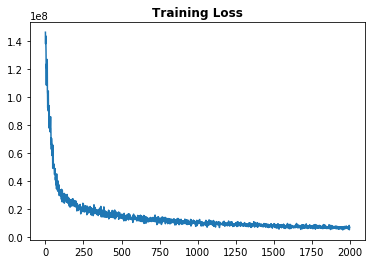

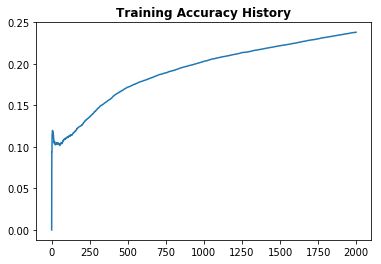

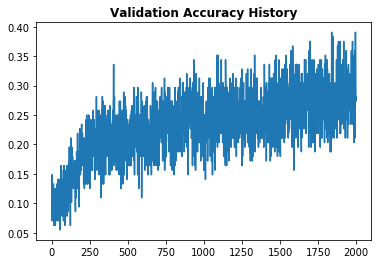

In [47]:
training_loop(X_train, y_train, X_test, y_test, num_epochs=2000)

## Validate the Network

Run the network against the validation data set to evaluate the classification effectiveness.

In [0]:
# TODO: Need to use a Saver to save the network weights so that we can validate
#       it in a separate session.
def validate(X, y):
  """
  Validates a CNN trained on the CIFAR-10 dataset.
  
  Parameters:
    - X:    The set of validation samples. 
    - y:    The ground truth labels for the samples.
  """

  # Create a placeholder for the input tensor (to be passed to the model).
  img = tf.placeholder(tf.float32, shape=X.shape)

  # Create a placeholder for the corresponding labels.
  img_labels = tf.placeholder(tf.float32, shape=y.shape)
  
  # Create an operation for the test time forward pass.
  test_op = forward_pass_test(img, img_labels)

  # Create the TF session and run the graph.
  with tf.Session() as sess:
    # Create a batch of the same size as the network.
    batch_size = 128
    inds = np.random.randint(0, X.shape[0], batch_size)
    batch = X[inds]
    batch_labels = y[inds]
    
    # Get the loss using the current weights in the graph. This call starts
    # the chain of operations in the computation graph created above.
    labels = sess.run(test_op, feed_dict={img: X, img_labels: y})
    
    print("Output Shape: {}".format(labels))

In [0]:
validate(X_test, y_test)

forward_pass_test


FailedPreconditionError: ignored

In [19]:
# Pooling Test

# Create some small dimensional "image" with each pixel as a random number
# between one and ten that will be easy to print and see the difference between
# original and pooled versions.
# 
# Note that I've put batch size, then channels first here (that way it displays
# better).
test_img = np.random.randint(10, size=(1,3,4,6))
print("Test Image:\n{}".format(test_img))

test_input_img = tf.placeholder(tf.float32, shape=test_img.shape)

with tf.Session() as sess:
  pool_window = [2,2]
  pool_type = "MAX"
  pad_type = "VALID" # This means we're not zero padding to keep dimensions the
                     # same. In other words, we're downsampling.
  data_format_str = "NCHW"  # N - batch size, C - channels, H - height, W - width
  stride_val = [2,2] # Don't overlap pooling windows.
  pooled = sess.run(tf.nn.pool(test_input_img, \
                               pool_window, \
                               pool_type, \
                               pad_type, \
                               strides=stride_val, \
                               data_format=data_format_str), \
                    feed_dict={test_input_img: test_img})
  
  print("Pooled:\n{}".format(pooled))

Test Image:
[[[[0 3 5 1 6 7]
   [3 5 5 0 4 3]
   [9 8 6 6 8 5]
   [4 2 9 4 5 6]]

  [[5 7 9 6 1 3]
   [4 5 0 9 5 0]
   [7 7 8 2 7 4]
   [3 4 1 4 4 8]]

  [[3 7 4 3 0 9]
   [2 5 0 9 3 6]
   [7 6 1 1 1 0]
   [3 3 2 7 8 2]]]]
Pooled:
[[[[5. 5. 7.]
   [9. 9. 8.]]

  [[7. 9. 5.]
   [7. 8. 8.]]

  [[7. 9. 9.]
   [7. 7. 8.]]]]


# What Did I Learn?

At first, I had three convolutional layers with no pooling between them.  Training accuracy goes up to about 25% after about 400 epochs (batch size 128) and then takes a dive.  Validation accuracy does about the same, but it is much more volatile.

Added pooling after each convolutional layer and took out the third convolutional layer because, after the second convolutional layer, the feature maps were only 8x8.  Slight improvement in training and validation accuracy (~30-35%), but that's still not very good at all.

Doubled the number of feature maps per convolutional layer.  Again, slight increase in accuracy.

Doubled the number of feature maps again for each convolutional layer.  About the same.

Decreased the learning rate by an order of magnitude.  Not sure if it was effective or not.

I think I need to check my accuracy calculation to make sure I'm not using it incorrectly.  Also, compare against known successful CIFAR-10 classifiers.